<a href="https://colab.research.google.com/github/KlymentievMaksym/IntelOb/blob/main/Lab5/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
layers = tf.keras.layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
# from DE import DE

# Read, Cache and Prefetch

In [4]:
batch_size = 32
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val = val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test = test.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# Augmentation

In [5]:
filepath_save = "./Models/Model_valAcc{val_accuracy:.2f}_valLoss{val_loss:.2f}.keras"
filepath_backup = "./Backups/"
callbacks = [
    # tf.keras.callbacks.ModelCheckpoint(filepath_save, monitor='val_accuracy', save_best_only=True),
    # tf.keras.callbacks.BackupAndRestore(filepath_backup),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
]

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.2),
])

# Visualisation

In [6]:
def summary_conv_and_last_dense(model):
    lines = []
    total_params = 0

    for layer in model.layers:
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.Dense):
            lines.append((layer.name, type(layer).__name__, layer.output.shape, layer.count_params()))
            total_params += layer.count_params()

    if lines:
        text = "----------------------------------------------------------------"
        text += f"\n{'Layer':<8}{'Output Shape':<20}{'Param #':>10}"
        text += "\n================================================================"
        for name, ltype, shape, params in lines:
            text += f"\n{ltype:<8}{str(shape):<20}{params:>10}"
        text += "\n================================================================"
        text += f"\nTotal params: {total_params}"
        print(text)
    else:
        print("No Conv2D or Dense layers found in the model.")

# Diff Evo and Func

In [ ]:
def DE(pop_size, iterations, function, limits, ints):
    dim = len(limits)
    limits = np.array(limits)
    x_low = limits[:, 0]
    x_high = limits[:, 1]

    population = np.random.uniform(x_low, x_high, (pop_size, dim))

    if ints:
        for it in ints:
            population[:, it] = np.round(population[:, it])

    max_f = -float('inf')
    best_f = float('inf')
    best_pop = np.zeros(dim)

    # function calls = pop_size + iterations * pop_size
    fitness = np.array([function(X) for X in population])
    for iteration in tqdm(
        range(iterations),
        desc="Processing",
        unit="step",
        bar_format="{l_bar}{bar:40}{r_bar}",
        colour='cyan',
        total=iterations
    ):
        for i in range(pop_size):
            F = np.random.uniform(1e-6, 2)
            P = np.random.uniform(1e-6, 1)
            r = np.random.uniform(1e-6, 1, dim)
            x1, x2, x3 = np.random.choice(population.shape[0], size=3, replace=False)
            while np.all(population[x1] == population[i]) or np.all(population[x2] == population[i]) or np.all(population[x3] == population[i]):
                x1, x2, x3 = np.random.choice(population.shape[0], size=3, replace=False)
            mutant_vector = population[x1] + F * (population[x2] - population[x3])
            mutant_vector[r < P] = population[i][r < P]
            if ints:
                for it in ints:
                    mutant_vector[it] = np.round(mutant_vector[it])
            mutant_vector = np.clip(mutant_vector, x_low, x_high)
            mutant_fitness = function(mutant_vector)
            if fitness[i] > mutant_fitness:
                fitness[i] = mutant_fitness
                population[i] = mutant_vector.copy()
        el_min = np.argmin(fitness)
        if best_f > fitness[el_min]:
            best_f = fitness[el_min]
            best_pop = population[el_min].copy()
        el_max = np.max(fitness)
        if max_f < el_max:
            max_f = el_max

    return best_f, best_pop

def func(X):
    X = X.astype(int)
    amount_of_layer_1 = X[0]
    amount_of_layer_2 = X[1]
    amount_of_layer_3 = X[2]
    amount_of_one_dence = X[3]
    amount_of_one_filters = X[4]

    model_layers = [
        layers.Input(shape=(32, 32, 3)),
        data_augmentation
    ]

    for _ in range(amount_of_layer_1):
        model_layers.append(layers.Conv2D(int(amount_of_one_filters), (3, 3), activation='relu', padding='same'))
        model_layers.append(layers.BatchNormalization())
    model_layers.append(layers.MaxPooling2D(2, 2))

    for _ in range(amount_of_layer_2):
        model_layers.append(layers.Conv2D(int(amount_of_one_filters * 2), (3, 3), activation='relu', padding='same'))
        model_layers.append(layers.BatchNormalization())
    model_layers.append(layers.MaxPooling2D(2, 2))
    model_layers.append(layers.Dropout(0.3))

    for _ in range(amount_of_layer_3):
        model_layers.append(layers.Conv2D(int(amount_of_one_filters * 4), (3, 3), activation='relu', padding='same'))
        model_layers.append(layers.BatchNormalization())
    model_layers.append(layers.MaxPooling2D(4, 4))
    model_layers.append(layers.Dropout(0.4))

    model_layers.append(layers.Flatten())
    for _ in range(amount_of_one_dence):
        model_layers.append(layers.Dense(int(amount_of_one_filters * 8), activation='relu'))
    model_layers.append(layers.Dropout(0.5))
    model_layers.append(layers.Dense(10, activation='softmax'))

    model = tf.keras.models.Sequential(model_layers)
    summary_conv_and_last_dense(model)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])
    history = model.fit(train, batch_size=batch_size, epochs=100, validation_data=(val), callbacks=callbacks)
    index = np.argmax(history.history['val_loss'])
    evaluation = model.evaluate(test)
    loss, acc, top2  = evaluation
    return (1.0 - acc) + loss

func_limits = [[1, 4], [0, 4], [0, 4], [1, 4], [16, 64]]


# Use DE

In [ ]:
best_f, best_d = DE(4, 4, func, func_limits, ints=[0, 1, 2, 3, 4])
best_f, best_d

----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 26)         728
Conv2D  (None, 16, 16, 52)       12220
Conv2D  (None, 16, 16, 52)       24388
Dense   (None, 208)              43472
Dense   (None, 208)              43472
Dense   (None, 208)              43472
Dense   (None, 208)              43472
Dense   (None, 10)                2090
Total params: 213314
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - Top2: 0.3602 - accuracy: 0.1898 - loss: 2.1832 - val_Top2: 0.5176 - val_accuracy: 0.2819 - val_loss: 1.9114
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - Top2: 0.5064 - accuracy: 0.2789 - loss: 1.8998 - val_Top2: 0.5601 - val_accuracy: 0.3014 - val_loss: 1.7894
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - Top2: 0.5449 - accuracy: 0.3066 - loss: 1.8257 - val_Top2: 0.4634 - val_accuracy: 0.2651 - val_loss: 1.9447
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - Top

Processing:   0%|                                        | 0/4 [00:00<?, ?step/s]

----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 26)         728
Conv2D  (None, 16, 16, 52)       12220
Conv2D  (None, 16, 16, 52)       24388
Dense   (None, 208)              43472
Dense   (None, 208)              43472
Dense   (None, 208)              43472
Dense   (None, 208)              43472
Dense   (None, 10)                2090
Total params: 213314
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - Top2: 0.3646 - accuracy: 0.1921 - loss: 2.1731 - val_Top2: 0.4280 - val_accuracy: 0.2274 - val_loss: 2.0155
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - Top2: 0.5134 - accuracy: 0.2782 - loss: 1.9023 - val_Top2: 0.5668 - val_accuracy: 0.3197 - val_loss: 1.7820
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - Top2: 0.5577 - accuracy: 0.3204 - loss: 1.8151 - val_Top2: 0.4862 - val_accuracy: 0.2941 - val_loss: 1.8781
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - Top

Processing:  25%|██████████                              | 1/4 [2:12:36<6:37:49, 7956.38s/step]

----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 46)        1288
Conv2D  (None, 32, 32, 46)       19090
Conv2D  (None, 16, 16, 92)       38180
Conv2D  (None, 16, 16, 92)       76268
Dense   (None, 368)             135792
Dense   (None, 368)             135792
Dense   (None, 368)             135792
Dense   (None, 368)             135792
Dense   (None, 10)                3690
Total params: 681684
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 102s 79ms/step - Top2: 0.4047 - accuracy: 0.2159 - loss: 2.1228 - val_Top2: 0.5298 - val_accuracy: 0.2923 - val_loss: 1.8542
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 99s 79ms/step - Top2: 0.5475 - accuracy: 0.3160 - loss: 1.8339 - val_Top2: 0.5863 - val_accuracy: 0.3598 - val_loss: 1.7346
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 99s 79ms/step - Top2: 0.6019 - accuracy: 0.3736 - loss: 1.7175 - val_Top2: 0.5425 - val_accuracy: 0.3347 - val_loss: 1.8361
Epoch 4/100
1250/1250 

Processing:  50%|████████████████████                    | 2/4 [6:21:09<6:41:37, 12048.55s/step]

----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 46)        1288
Conv2D  (None, 32, 32, 46)       19090
Conv2D  (None, 32, 32, 46)       19090
Conv2D  (None, 32, 32, 46)       19090
Conv2D  (None, 16, 16, 92)       38180
Conv2D  (None, 16, 16, 92)       76268
Conv2D  (None, 16, 16, 92)       76268
Conv2D  (None, 16, 16, 92)       76268
Dense   (None, 368)             135792
Dense   (None, 368)             135792
Dense   (None, 368)             135792
Dense   (None, 10)                3690
Total params: 736608
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 237s 186ms/step - Top2: 0.3975 - accuracy: 0.2166 - loss: 2.2168 - val_Top2: 0.4362 - val_accuracy: 0.2311 - val_loss: 2.0203
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 227s 182ms/step - Top2: 0.5431 - accuracy: 0.3122 - loss: 1.8332 - val_Top2: 0.5637 - val_accuracy: 0.3253 - val_loss: 1.9182
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 228s 182ms/step - Top2: 0.

Processing:  75%|██████████████████████████████          | 3/4 [12:20:34<4:33:13, 16393.79s/step]

----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 36)        1008
Conv2D  (None, 32, 32, 36)       11700
Conv2D  (None, 32, 32, 36)       11700
Conv2D  (None, 32, 32, 36)       11700
Conv2D  (None, 16, 16, 72)       23400
Conv2D  (None, 16, 16, 72)       46728
Conv2D  (None, 16, 16, 72)       46728
Conv2D  (None, 16, 16, 72)       46728
Dense   (None, 288)              83232
Dense   (None, 10)                2890
Total params: 285814
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 193s 151ms/step - Top2: 0.3475 - accuracy: 0.1848 - loss: 2.7659 - val_Top2: 0.4980 - val_accuracy: 0.2825 - val_loss: 1.9081
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 178s 143ms/step - Top2: 0.4777 - accuracy: 0.2519 - loss: 1.9543 - val_Top2: 0.5056 - val_accuracy: 0.2851 - val_loss: 1.9106
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 178s 142ms/step - Top2: 0.5327 - accuracy: 0.2916 - loss: 1.8656 - val_Top2: 0.4587 - val_accuracy: 0.26

Processing: 100%|████████████████████████████████████████| 4/4 [19:10:20<00:00, 17255.16s/step]  


(np.float64(0.9463974833488464), array([ 4.,  4.,  2.,  1., 38.]))

# Bests apart

In [ ]:
best_f, best_d

(np.float64(0.9463974833488464), array([ 4.,  4.,  2.,  1., 38.]))

# Standart and modernised

In [ ]:
def display_history(history, names, title):
    plt.figure()
    plt.title(title)
    plt.plot(history.history[names[0]], label=names[0])
    plt.plot(history.history[names[1]], label=names[1])
    plt.xlabel("Epochs")
    plt.ylabel(names[0])
    plt.legend()
    plt.show()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
]

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,590,922 (13.70 MB)

 Trainable params: 3,589,130 (13.69 MB)

 Non-trainable params: 1,792 (7.00 KB)

----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 128)       3584
Conv2D  (None, 16, 16, 256)     295168
Conv2D  (None, 8, 8, 512)      1180160
Dense   (None, 1024)           2098176
Dense   (None, 10)               10250
Total params: 3587338
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - Top2: 0.4026 - accuracy: 0.2237 - loss: 2.7898 - val_Top2: 0.4792 - val_accuracy: 0.2791 - val_loss: 2.0310
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - Top2: 0.5343 - accuracy: 0.3114 - loss: 1.8744 - val_Top2: 0.5756 - val_accuracy: 0.3498 - val_loss: 1.7950
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - Top2: 0.5662 - accuracy: 0.3443 - loss: 1.7989 - val_Top2: 0.6563 - val_accuracy: 0.4309 - val_loss: 1.5734
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - Top2: 0.5972 - accuracy: 0.3702 - loss: 1.7240 - val_Top2: 0.6132 - val_accuracy: 0.3858 - val_loss: 1.6870
Epoch 5/100

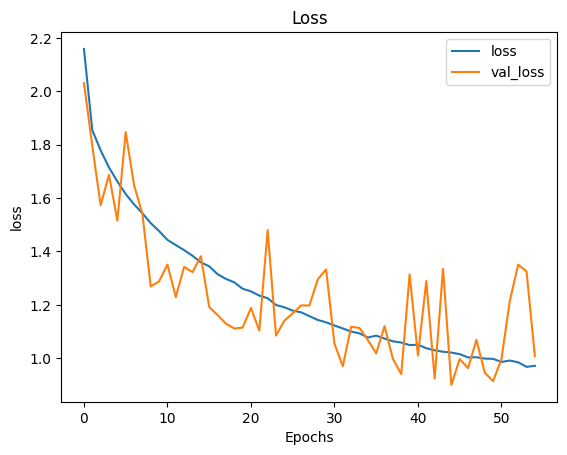

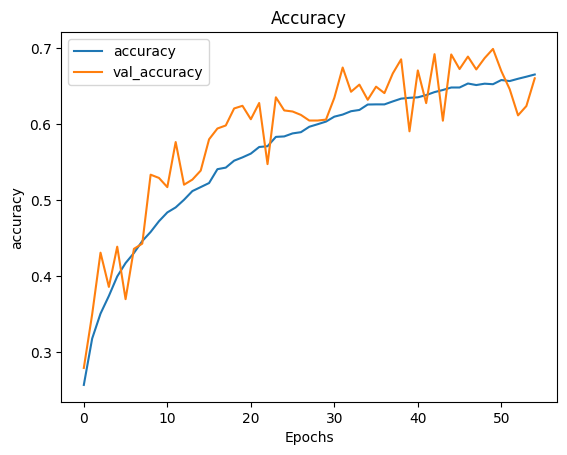

In [ ]:
amount_of_layer_1 = 1
amount_of_layer_2 = 1
amount_of_layer_3 = 1
amount_of_one_dence = 1
amount_of_one_filters = 128

model_layers = [
    layers.Input(shape=(32, 32, 3)),
    data_augmentation
]

for _ in range(amount_of_layer_1):
    model_layers.append(layers.Conv2D(int(amount_of_one_filters), (3, 3), activation='relu', padding='same'))
    model_layers.append(layers.BatchNormalization())
model_layers.append(layers.MaxPooling2D(2, 2))

for _ in range(amount_of_layer_2):
    model_layers.append(layers.Conv2D(int(amount_of_one_filters * 2), (3, 3), activation='relu', padding='same'))
    model_layers.append(layers.BatchNormalization())
model_layers.append(layers.MaxPooling2D(2, 2))
model_layers.append(layers.Dropout(0.3))

for _ in range(amount_of_layer_3):
    model_layers.append(layers.Conv2D(int(amount_of_one_filters * 4), (3, 3), activation='relu', padding='same'))
    model_layers.append(layers.BatchNormalization())
model_layers.append(layers.MaxPooling2D(4, 4))
model_layers.append(layers.Dropout(0.4))

model_layers.append(layers.Flatten())
for _ in range(amount_of_one_dence):
    model_layers.append(layers.Dense(int(amount_of_one_filters * 8), activation='relu'))
model_layers.append(layers.Dropout(0.5))
model_layers.append(layers.Dense(10, activation='softmax'))

model = tf.keras.models.Sequential(model_layers)
model.summary()
# print(model.count_params())
summary_conv_and_last_dense(model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])
history = model.fit(train, batch_size=batch_size, epochs=100, validation_data=(val), callbacks=callbacks)
index = np.argmax(history.history['val_loss'])
evaluation = model.evaluate(test)
display_history(history, ['loss', 'val_loss'], "Loss")
display_history(history, ['accuracy', 'val_accuracy'], "Accuracy")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 38)     │         1,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 38)     │           152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 38)     │        13,034 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 38)     │           152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 38)     │        13,034 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 38)     │           152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 38)     │        13,034 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 38)     │           152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 38)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 76)     │        26,068 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 76)     │           304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 76)     │        52,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 76)     │           304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 76)     │        52,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 76)     │           304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 76)     │        52,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 76)     │           304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 76)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 76)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 152)      │       104,12

 Total params: 725,848 (2.77 MB)

 Trainable params: 724,328 (2.76 MB)

 Non-trainable params: 1,520 (5.94 KB)

----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 38)        1064
Conv2D  (None, 32, 32, 38)       13034
Conv2D  (None, 32, 32, 38)       13034
Conv2D  (None, 32, 32, 38)       13034
Conv2D  (None, 16, 16, 76)       26068
Conv2D  (None, 16, 16, 76)       52060
Conv2D  (None, 16, 16, 76)       52060
Conv2D  (None, 16, 16, 76)       52060
Conv2D  (None, 8, 8, 152)       104120
Conv2D  (None, 8, 8, 152)       208088
Dense   (None, 304)             185136
Dense   (None, 10)                3050
Total params: 722808
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - Top2: 0.3874 - accuracy: 0.2105 - loss: 2.4243 - val_Top2: 0.5365 - val_accuracy: 0.3004 - val_loss: 1.8955
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - Top2: 0.5352 - accuracy: 0.3047 - loss: 1.8700 - val_Top2: 0.6145 - val_accuracy: 0.3743 - val_loss: 1.7106
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - Top2: 0.5924 -

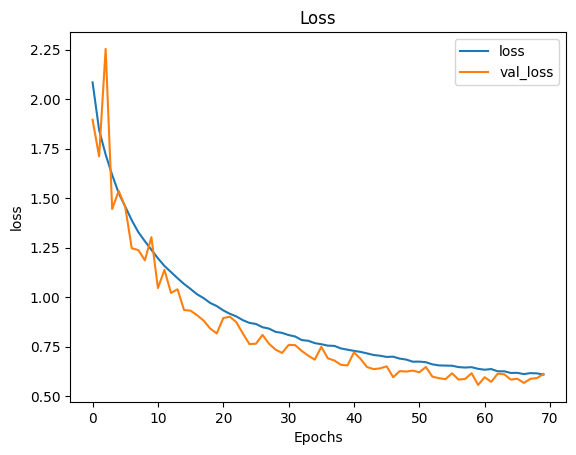

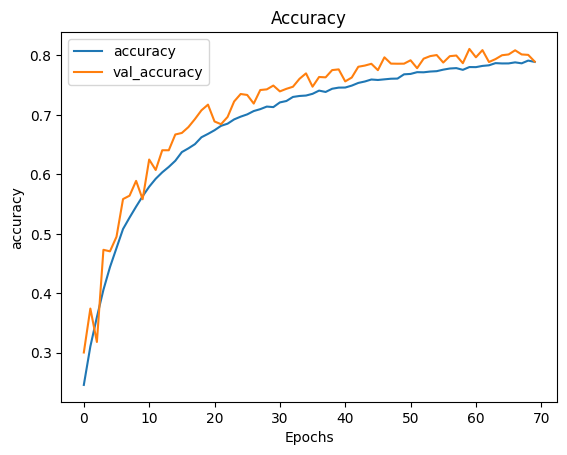

In [ ]:
amount_of_layer_1 = 4
amount_of_layer_2 = 4
amount_of_layer_3 = 2
amount_of_one_dence = 1
amount_of_one_filters = 38

model_layers = [
    layers.Input(shape=(32, 32, 3)),
    data_augmentation
]

for _ in range(amount_of_layer_1):
    model_layers.append(layers.Conv2D(int(amount_of_one_filters), (3, 3), activation='relu', padding='same'))
    model_layers.append(layers.BatchNormalization())
model_layers.append(layers.MaxPooling2D(2, 2))

for _ in range(amount_of_layer_2):
    model_layers.append(layers.Conv2D(int(amount_of_one_filters * 2), (3, 3), activation='relu', padding='same'))
    model_layers.append(layers.BatchNormalization())
model_layers.append(layers.MaxPooling2D(2, 2))
model_layers.append(layers.Dropout(0.3))

for _ in range(amount_of_layer_3):
    model_layers.append(layers.Conv2D(int(amount_of_one_filters * 4), (3, 3), activation='relu', padding='same'))
    model_layers.append(layers.BatchNormalization())
model_layers.append(layers.MaxPooling2D(4, 4))
model_layers.append(layers.Dropout(0.4))

model_layers.append(layers.Flatten())
for _ in range(amount_of_one_dence):
    model_layers.append(layers.Dense(int(amount_of_one_filters * 8), activation='relu'))
model_layers.append(layers.Dropout(0.5))
model_layers.append(layers.Dense(10, activation='softmax'))

model = tf.keras.models.Sequential(model_layers)
model.summary()
# print(model.count_params())
summary_conv_and_last_dense(model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])
history = model.fit(train, batch_size=batch_size, epochs=100, validation_data=(val), callbacks=callbacks)
index = np.argmax(history.history['val_loss'])
evaluation = model.evaluate(test)
display_history(history, ['loss', 'val_loss'], "Loss")
display_history(history, ['accuracy', 'val_accuracy'], "Accuracy")

# Plains

## Func

In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
]

In [8]:
def func(X):
    amount_of_layer_1 = 4
    amount_of_layer_2 = 4
    amount_of_layer_3 = 2
    amount_of_one_dence = 1
    amount_of_one_filters = int(round(X[0]))
    Dropout = X[1]
    model_layers = [
        layers.Input(shape=(32, 32, 3)),
        data_augmentation
    ]

    for _ in range(amount_of_layer_1):
        model_layers.append(layers.Conv2D(amount_of_one_filters, (3, 3), activation='relu', padding='same'))
        model_layers.append(layers.BatchNormalization())
    model_layers.append(layers.MaxPooling2D(2, 2))

    for _ in range(amount_of_layer_2):
        model_layers.append(layers.Conv2D(amount_of_one_filters * 2, (3, 3), activation='relu', padding='same'))
        model_layers.append(layers.BatchNormalization())
    model_layers.append(layers.MaxPooling2D(2, 2))
    model_layers.append(layers.Dropout(Dropout))

    for _ in range(amount_of_layer_3):
        model_layers.append(layers.Conv2D(amount_of_one_filters * 4, (3, 3), activation='relu', padding='same'))
        model_layers.append(layers.BatchNormalization())
    model_layers.append(layers.MaxPooling2D(4, 4))
    model_layers.append(layers.Dropout(Dropout + 0.1))

    model_layers.append(layers.Flatten())
    for _ in range(amount_of_one_dence):
        model_layers.append(layers.Dense(amount_of_one_filters * 8, activation='relu'))
    model_layers.append(layers.Dropout(Dropout + 0.2))
    model_layers.append(layers.Dense(10, activation='softmax'))

    model = tf.keras.models.Sequential(model_layers)
    summary_conv_and_last_dense(model)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="Top2")])
    history = model.fit(train, batch_size=batch_size, epochs=100, validation_data=(val), callbacks=callbacks)
    index = np.argmax(history.history['val_loss'])
    evaluation = model.evaluate(test)
    # print(model.metrics_names)
    # print(evaluation)
    loss, acc, top2  = evaluation
    # return (1.0 - history.history['val_accuracy'][index]) + history.history['val_loss'][index]
    return (1.0 - acc) + loss

func_limits = [[16, 64], [0.1, 0.6]]

## Configuration

In [9]:
dots = 3
x1_lim = func_limits[0]
x1 = np.linspace(x1_lim[0], x1_lim[1], dots)
x2_lim = func_limits[1]
x2 = np.linspace(x2_lim[0], x2_lim[1], dots)
space = np.meshgrid(x1, x2)
space

[array([[16., 40., 64.],
        [16., 40., 64.],
        [16., 40., 64.]]),
 array([[0.1 , 0.1 , 0.1 ],
        [0.35, 0.35, 0.35],
        [0.6 , 0.6 , 0.6 ]])]

In [10]:
def wrapped_func(filters, dropout):
    return func(np.array([filters, dropout]))

vectorized_func = np.vectorize(wrapped_func)

fitness = vectorized_func(*space)


----------------------------------------------------------------
Layer   Output Shape           Param #
Conv2D  (None, 32, 32, 16)         448
Conv2D  (None, 32, 32, 16)        2320
Conv2D  (None, 32, 32, 16)        2320
Conv2D  (None, 32, 32, 16)        2320
Conv2D  (None, 16, 16, 32)        4640
Conv2D  (None, 16, 16, 32)        9248
Conv2D  (None, 16, 16, 32)        9248
Conv2D  (None, 16, 16, 32)        9248
Conv2D  (None, 8, 8, 64)         18496
Conv2D  (None, 8, 8, 64)         36928
Dense   (None, 128)              32896
Dense   (None, 10)                1290
Total params: 129402
Epoch 1/100


E0000 00:00:1747298710.110833      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1747298712.529341      76 cuda_dnn.cc:529] Loaded cuDNN version 90300


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - Top2: 0.3766 - accuracy: 0.2090 - loss: 2.2861 - val_Top2: 0.5361 - val_accuracy: 0.3164 - val_loss: 1.9115
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - Top2: 0.5509 - accuracy: 0.3209 - loss: 1.8244 - val_Top2: 0.6001 - val_accuracy: 0.3629 - val_loss: 1.7240
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - Top2: 0.6094 - accuracy: 0.3772 - loss: 1.7048 - val_Top2: 0.6386 - val_accuracy: 0.4124 - val_loss: 1.5974
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - Top2: 0.6474 - accuracy: 0.4118 - loss: 1.6077 - val_Top2: 0.6622 - val_accuracy: 0.4305 - val_loss: 1.5688
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - Top2: 0.6819 - accuracy: 0.4499 - loss: 1.5169 - val_Top2: 0.6747 - val_accuracy: 0.4687 - val_loss: 1.4983
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - Top2: 0.7009 - accuracy: 0.4762 - loss: 1.4509 - val_Top2: 0.7214 - val_accuracy: 0.5187 - val_loss: 1.3489
Epoch 7/10

E0000 00:00:1747299351.106449      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - Top2: 0.3758 - accuracy: 0.2037 - loss: 2.2986 - val_Top2: 0.5379 - val_accuracy: 0.3242 - val_loss: 1.8403
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - Top2: 0.5449 - accuracy: 0.3182 - loss: 1.8450 - val_Top2: 0.5484 - val_accuracy: 0.3528 - val_loss: 1.8962
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - Top2: 0.6058 - accuracy: 0.3782 - loss: 1.7084 - val_Top2: 0.6556 - val_accuracy: 0.4207 - val_loss: 1.5851
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - Top2: 0.6462 - accuracy: 0.4238 - loss: 1.5937 - val_Top2: 0.6374 - val_accuracy: 0.4314 - val_loss: 1.6438
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - Top2: 0.6811 - accuracy: 0.4519 - loss: 1.5031 - val_Top2: 0.6307 - val_accuracy: 0.4297 - val_loss: 1.6162
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - Top2: 0.7118 - accuracy: 0.4812 - loss: 1.4276 - val_Top2: 0.7086 - val_accuracy: 0.5033 - val_loss: 1.4020
Epoch 7/10

E0000 00:00:1747300406.122399      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/dropout_6_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - Top2: 0.4317 - accuracy: 0.2445 - loss: 2.2233 - val_Top2: 0.5923 - val_accuracy: 0.3500 - val_loss: 1.7086
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - Top2: 0.5898 - accuracy: 0.3565 - loss: 1.7387 - val_Top2: 0.6004 - val_accuracy: 0.4027 - val_loss: 1.7189
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - Top2: 0.6666 - accuracy: 0.4335 - loss: 1.5570 - val_Top2: 0.6823 - val_accuracy: 0.4497 - val_loss: 1.5541
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - Top2: 0.7052 - accuracy: 0.4784 - loss: 1.4434 - val_Top2: 0.7043 - val_accuracy: 0.5091 - val_loss: 1.4277
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - Top2: 0.7322 - accuracy: 0.5155 - loss: 1.3561 - val_Top2: 0.7543 - val_accuracy: 0.5385 - val_loss: 1.2728
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - Top2: 0.7487 - accuracy: 0.5447 - loss: 1.2873 - val_Top2: 0.7793 - val_accuracy: 0.6008 - val_loss: 1.1624
Epoch 7/10

E0000 00:00:1747301375.994762      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_9_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - Top2: 0.4300 - accuracy: 0.2454 - loss: 2.3428 - val_Top2: 0.4938 - val_accuracy: 0.2899 - val_loss: 1.9582
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.5864 - accuracy: 0.3577 - loss: 1.7558 - val_Top2: 0.5742 - val_accuracy: 0.3692 - val_loss: 1.9090
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.6568 - accuracy: 0.4288 - loss: 1.5783 - val_Top2: 0.5644 - val_accuracy: 0.3690 - val_loss: 2.0664
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.7054 - accuracy: 0.4816 - loss: 1.4427 - val_Top2: 0.6874 - val_accuracy: 0.4850 - val_loss: 1.4738
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - Top2: 0.7320 - accuracy: 0.5195 - loss: 1.3486 - val_Top2: 0.6850 - val_accuracy: 0.4877 - val_loss: 1.6862
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.7539 - accuracy: 0.5501 - loss: 1.2824 - val_Top2: 0.7361 - val_accuracy: 0.5687 - val_loss: 1.2875
Epoch 7/10

E0000 00:00:1747302462.568751      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_5_1/dropout_12_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - Top2: 0.2371 - accuracy: 0.1223 - loss: 2.7143 - val_Top2: 0.4276 - val_accuracy: 0.2167 - val_loss: 2.0082
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - Top2: 0.4121 - accuracy: 0.2159 - loss: 2.0727 - val_Top2: 0.5179 - val_accuracy: 0.2971 - val_loss: 1.8886
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - Top2: 0.4915 - accuracy: 0.2644 - loss: 1.9430 - val_Top2: 0.5421 - val_accuracy: 0.2977 - val_loss: 1.8498
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - Top2: 0.5316 - accuracy: 0.2886 - loss: 1.8668 - val_Top2: 0.5559 - val_accuracy: 0.3137 - val_loss: 1.7555
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - Top2: 0.5548 - accuracy: 0.3149 - loss: 1.8050 - val_Top2: 0.6107 - val_accuracy: 0.3684 - val_loss: 1.6572
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - Top2: 0.5925 - accuracy: 0.3503 - loss: 1.7395 - val_Top2: 0.6424 - val_accuracy: 0.4022 - val_loss: 1.5753
Epoch 7/10

E0000 00:00:1747303137.984867      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_6_1/dropout_15_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - Top2: 0.3503 - accuracy: 0.1862 - loss: 2.5987 - val_Top2: 0.4989 - val_accuracy: 0.2637 - val_loss: 2.0312
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - Top2: 0.5054 - accuracy: 0.2775 - loss: 1.9253 - val_Top2: 0.5650 - val_accuracy: 0.3296 - val_loss: 1.8486
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - Top2: 0.5719 - accuracy: 0.3331 - loss: 1.7941 - val_Top2: 0.6489 - val_accuracy: 0.4058 - val_loss: 1.5870
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - Top2: 0.6191 - accuracy: 0.3762 - loss: 1.6754 - val_Top2: 0.6760 - val_accuracy: 0.4335 - val_loss: 1.5294
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - Top2: 0.6632 - accuracy: 0.4192 - loss: 1.5838 - val_Top2: 0.7115 - val_accuracy: 0.4697 - val_loss: 1.4243
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - Top2: 0.6874 - accuracy: 0.4468 - loss: 1.5085 - val_Top2: 0.7256 - val_accuracy: 0.5269 - val_loss: 1.3381
Epoch 7/10

E0000 00:00:1747303999.006688      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_7_1/dropout_18_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - Top2: 0.3820 - accuracy: 0.2065 - loss: 2.6016 - val_Top2: 0.5377 - val_accuracy: 0.2893 - val_loss: 1.8535
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.5079 - accuracy: 0.2852 - loss: 1.9174 - val_Top2: 0.5931 - val_accuracy: 0.3472 - val_loss: 1.7532
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.5683 - accuracy: 0.3279 - loss: 1.8033 - val_Top2: 0.5996 - val_accuracy: 0.3701 - val_loss: 1.7169
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.6236 - accuracy: 0.3818 - loss: 1.6784 - val_Top2: 0.6515 - val_accuracy: 0.4286 - val_loss: 1.5767
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.6654 - accuracy: 0.4268 - loss: 1.5890 - val_Top2: 0.6890 - val_accuracy: 0.4697 - val_loss: 1.5906
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.6947 - accuracy: 0.4589 - loss: 1.4962 - val_Top2: 0.7048 - val_accuracy: 0.5079 - val_loss: 1.4062
Epoch 7/10

E0000 00:00:1747305350.875962      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_8_1/dropout_21_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - Top2: 0.2065 - accuracy: 0.1036 - loss: 3.8878 - val_Top2: 0.2026 - val_accuracy: 0.1174 - val_loss: 2.2974
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - Top2: 0.1997 - accuracy: 0.1025 - loss: 2.3060 - val_Top2: 0.3235 - val_accuracy: 0.1595 - val_loss: 2.2675
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - Top2: 0.2250 - accuracy: 0.1117 - loss: 2.2914 - val_Top2: 0.2643 - val_accuracy: 0.1419 - val_loss: 2.2715
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - Top2: 0.2516 - accuracy: 0.1293 - loss: 2.2757 - val_Top2: 0.3324 - val_accuracy: 0.1593 - val_loss: 2.2000
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - Top2: 0.2735 - accuracy: 0.1422 - loss: 2.2457 - val_Top2: 0.3942 - val_accuracy: 0.1979 - val_loss: 2.0557
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - Top2: 0.3212 - accuracy: 0.1654 - loss: 2.1886 - val_Top2: 0.4486 - val_accuracy: 0.2313 - val_loss: 2.0094
Epoch 7/10

E0000 00:00:1747306199.267971      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_9_1/dropout_24_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - Top2: 0.2068 - accuracy: 0.1043 - loss: 3.7292 - val_Top2: 0.2335 - val_accuracy: 0.1148 - val_loss: 2.3006
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - Top2: 0.1983 - accuracy: 0.0999 - loss: 2.3069 - val_Top2: 0.2947 - val_accuracy: 0.1521 - val_loss: 2.2430
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - Top2: 0.2323 - accuracy: 0.1165 - loss: 2.2821 - val_Top2: 0.3053 - val_accuracy: 0.1443 - val_loss: 2.3045
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - Top2: 0.2960 - accuracy: 0.1460 - loss: 2.2206 - val_Top2: 0.4029 - val_accuracy: 0.1941 - val_loss: 2.0807
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - Top2: 0.3273 - accuracy: 0.1648 - loss: 2.1788 - val_Top2: 0.4022 - val_accuracy: 0.1972 - val_loss: 2.0697
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - Top2: 0.3536 - accuracy: 0.1788 - loss: 2.1454 - val_Top2: 0.3951 - val_accuracy: 0.1979 - val_loss: 2.0452
Epoch 7/10

E0000 00:00:1747306958.467920      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_10_1/dropout_27_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - Top2: 0.2613 - accuracy: 0.1345 - loss: 3.7893 - val_Top2: 0.3647 - val_accuracy: 0.1818 - val_loss: 2.1085
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.3688 - accuracy: 0.1919 - loss: 2.1478 - val_Top2: 0.4461 - val_accuracy: 0.2348 - val_loss: 1.9884
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.4059 - accuracy: 0.2148 - loss: 2.0944 - val_Top2: 0.3972 - val_accuracy: 0.2065 - val_loss: 2.1803
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.4392 - accuracy: 0.2267 - loss: 2.0304 - val_Top2: 0.4270 - val_accuracy: 0.2347 - val_loss: 2.0445
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.4685 - accuracy: 0.2515 - loss: 1.9856 - val_Top2: 0.5601 - val_accuracy: 0.3258 - val_loss: 1.7703
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - Top2: 0.4970 - accuracy: 0.2697 - loss: 1.9290 - val_Top2: 0.4495 - val_accuracy: 0.2305 - val_loss: 2.0644
Epoch 7/10

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in wrapped_func (vectorized)
  outputs = ufunc(*inputs)


In [11]:
fitness

array([[1.15396696, 0.88288867, 0.82192647],
       [1.40511823, 0.9627502 , 0.82959312],
       [1.7300483 , 1.87406519, 2.31102026]])

## Plotting

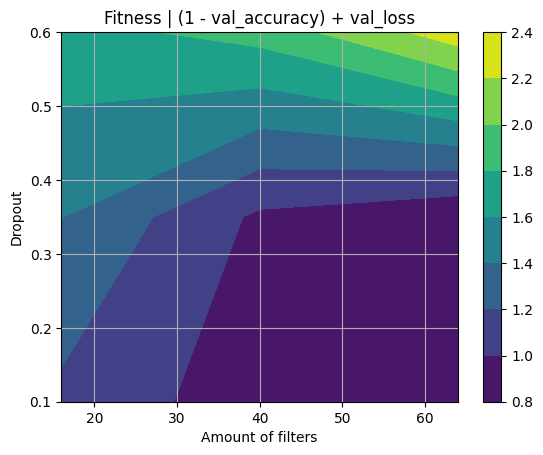

In [12]:
colorbar = plt.contourf(*space, fitness)
plt.gcf().colorbar(colorbar)
plt.title("Fitness | (1 - val_accuracy) + val_loss")
plt.xlabel("Amount of filters")
plt.ylabel("Dropout")
plt.grid(True)
plt.show()